In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import mudata 
import matplotlib.pyplot as plt
import seaborn as sns

# Description:

This notebook is similar to 10_grn_analysis.ipynb. We add some plot code block to show the regulation difference.

##  Load annotation data, regulation data, rna data

In [2]:
e_direct = pd.read_csv('/home/rsun@ZHANGroup.local/sly_data/sly_07_exfig/global_grn/scplus_pipeline/Snakemake/eRegulon_direct.tsv', sep='\t')
print(e_direct.loc[:,'eRegulon_name'].unique().shape)

auc_direct = mudata.read('/home/rsun@ZHANGroup.local/sly_data/sly_07_exfig/global_grn/scplus_pipeline/Snakemake/AUCell_direct.h5mu')

cell_data = pd.read_csv('/home/rsun@ZHANGroup.local/sly_data/sly_07_exfig/global_grn/scenic_brain_out/cell_data.csv', index_col = 0)


scdata = auc_direct['Gene_based'] 
scdata.obs = cell_data.loc[scdata.obs.index,:]

exp_data = sc.read_h5ad('/home/rsun@ZHANGroup.local/cross_embed/data/species_raw.h5ad')
new_idx = []
for ele in exp_data.obs.index:
    a, b, c = ele.split('-')
    new_idx.append(b + '-' + c +  '_' + a)
exp_data.obs.index = new_idx 

exp_data = exp_data[scdata.obs.index,:]
assert (exp_data.obs.index == scdata.obs.index).all()

(132,)


/home/rsun@ZHANGroup.local/anaconda3/envs/snapatac/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/rsun@ZHANGroup.local/anaconda3/envs/snapatac/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


## Save only +/+ or -/- eRegulon

In [ ]:
module_list = []
tf_list = []
sel_idx = []
for ele in scdata.var.index:
    a,b,c,d = ele.split('_')

    if c == '+/+':
        module_list.append(f'{a}(+)')
        sel_idx.append(True)
        tf_list.append(a)
    elif c == '-/-':
        module_list.append(f'{a}(-)')
        sel_idx.append(True)
        tf_list.append(a)
    else:
        sel_idx.append(False)
print(len(module_list)) 

scdata = scdata[:,sel_idx]
scdata.var.index = module_list 
exp_data = exp_data[:,tf_list]
exp_data.var.index = module_list

77


/tmp/ipykernel_1704469/3430144141.py:20: ImplicitModificationWarning: Trying to modify index of attribute `.var` of view, initializing view as actual.
  scdata.var.index = module_list


In [9]:
from sklearn.preprocessing import StandardScaler

def _scale(X: pd.DataFrame) -> pd.DataFrame:
    return (X - X.min()) / (X.max() - X.min())

def z_scale(df):
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index = df.index)
    return df

def sum_scale(df):
    new_df = df / df.sum(axis = 0).values
    return new_df

## For each species, extract and save the data for plotting

For each species, for each tissue, extract the regulation data for 7 celltype.


In [8]:
import os 
save_dir = 'species_celltype_plot'
os.makedirs(save_dir, exist_ok=True)

In [20]:
sel_tf = ['Dlx1(+)','Dlx2(+)','Arx(+)','Junb(+)','Neurod1(+)','Uncx(+)','Zic2(+)','Sox10(+)','Sox2(+)','Sox8(+)','Pgr(+)','Rarb(+)',
          'Pou6f1(+)','Tfap2a(+)','Bach1(+)','Klf4(+)','Esr1(+)','Six1(+)','Lef1(+)','Prdm5(+)','Sox6(+)','Sox9(+)','Elk3(+)',
          'Etv6(+)','Fli1(+)','Irf5(+)','Irf8(+)']


for key in scdata.obs.species.unique():
    species_reg = {}
    species_tf = {}

    idx = scdata.obs.species == key
    subdata = scdata[idx,:]
    sub_exp = exp_data[idx,:]
    
    for ele in subdata.obs.celltype.unique():
        idx2 = subdata.obs.celltype == ele
        tmp = subdata[idx2,:].X.mean(axis = 0)
        species_reg[ele] = tmp

        tmp = np.array(sub_exp[idx2,:].X.mean(axis = 0)).reshape(-1)
        species_tf[ele] = tmp

    reg_df = pd.DataFrame(species_reg)

    reg_df = reg_df.T
    reg_df.columns = scdata.var.index
    reg_df = reg_df.loc[:,sel_tf]
    reg_df= reg_df.loc[scdata.obs.celltype.unique(),:]
    reg_df = sum_scale(reg_df)
    reg_df.to_csv(os.path.join(save_dir, f'{key}_regulation.csv')) 

    tf_df = pd.DataFrame(species_tf)
    tf_df = tf_df.T 
    tf_df.columns = scdata.var.index 
    tf_df = tf_df.loc[:,sel_tf]
    tf_df = tf_df.loc[scdata.obs.celltype.unique(),:]
    tf_df = z_scale(tf_df) 
    tf_df.to_csv(os.path.join(save_dir, f'{key}_tf.csv'))


    #plt.figure(figsize = (30,4))
    #sns.heatmap(reg_df, cmap = 'RdYlBu_r', vmax = 0.5)
    #plt.title(f'{key} brain regulation among 7 celltype')
    #plt.savefig(os.path.join(save_dir,f'{key}_brain_regulation_filter.pdf'), bbox_inches = 'tight')
    #plt.show() 

    #reg_df.to_csv(os.path.join(save_dir, f'{key}_regulation.csv'))

### Regulation heatmap + dotplot combine

In [23]:
### import matplotlib.pyplot as plt
import seaborn as sns
import math 
#def tf_reg_plot():

HEATMAP_COLOR_MIN = 0
HEATMAP_COLOR_MAX = 0.5
HEATMAP_CMAP = "RdYlBu_r" 

# Dot plot 大小映射参数
DOT_MIN_VALUE = 0 # 只有当 dot_df 值大于等于此阈值时才绘制点
DOT_SIZE_BASE = 50   # 点的最小面积 (pixels)
DOT_SIZE_SCALE_FACTOR = 400 # 映射到点面积的缩放因子



# --- 3. 抽象绘制函数 (与之前相同，它本身就是通用的) ---
def plot_abstract_heatmap_dots(
    ax,
    heatmap_df: pd.DataFrame,
    dotplot_df: pd.DataFrame,
    title: str,
    heatmap_color_min: float,
    heatmap_color_max: float,
    heatmap_cmap: str,
    dot_min_value: float,
    dot_size_base: float,
    dot_size_scale_factor: float
):
    """
    绘制抽象的 Dot plot + Heatmap 组合图。

    Args:
        ax (matplotlib.axes.Axes): 要在其上绘图的 Axes 对象。
        heatmap_df (pd.DataFrame): 决定热力图颜色的 DataFrame。
        dotplot_df (pd.DataFrame): 决定点大小的 DataFrame，与 heatmap_df 形状相同。
        title (str): 子图的标题。
        sample_colors (dict): 字典，映射 sample_label 到颜色。
        feature_colors (dict): 字典，映射 feature_label 到颜色。
        heatmap_color_min (float): 热力图颜色映射的最小值。
        heatmap_color_max (float): 热力图颜色映射的最大值。
        heatmap_cmap (str): 热力图的 Colormap 名称。
        dot_min_value (float): 只有当 dotplot_df 值大于等于此阈值时才绘制点。
        dot_size_base (float): 点的最小面积 (pixels)。
        dot_size_scale_factor (float): 映射到点面积的缩放因子。
    """
    # 确保两个 DataFrame 的索引和列顺序一致
    if not heatmap_df.index.equals(dotplot_df.index) or \
       not heatmap_df.columns.equals(dotplot_df.columns):
        raise ValueError("heatmap_df and dotplot_df must have identical indices and columns.")

    # 绘制 Heatmap
    sns.heatmap(
        heatmap_df,
        ax=ax,
        cmap=heatmap_cmap,
        cbar=False,
        vmin=heatmap_color_min,
        vmax=heatmap_color_max,
        linewidths=0.5,
        linecolor='lightgray',
    )

    # 绘制 Dots
    # 遍历每个单元格来绘制点
    for i, sample_label in enumerate(heatmap_df.index):
        for j, feature_label in enumerate(heatmap_df.columns):
            dot_val = dotplot_df.loc[sample_label, feature_label]

            # 只有当 dot_val 达到一定阈值时才绘制点
            if dot_val >= dot_min_value:
                # 映射 dot_val 到点的大小 (面积)
                # 假设 dot_min_value 到 dotplot_df.max().max() 是点大小的有效范围
                normalized_dot_val = (dot_val - dot_min_value) / (dotplot_df.max().max() - dot_min_value)
                
                s = math.sqrt(normalized_dot_val) * dot_size_scale_factor + dot_size_base

                ax.scatter(j + 0.5, i + 0.5, s=s, color='black', edgecolor='black', zorder=2)

    ax.set_title(title, loc='right', fontsize=18, va='center')
    ax.tick_params(axis='y', rotation=0)
    ax.tick_params(axis='x', rotation=90)


    # 隐藏坐标轴刻度线和标签
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xlabel('')
    ax.set_ylabel('')


/tmp/ipykernel_1704469/2564497544.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以适应颜色条和图例


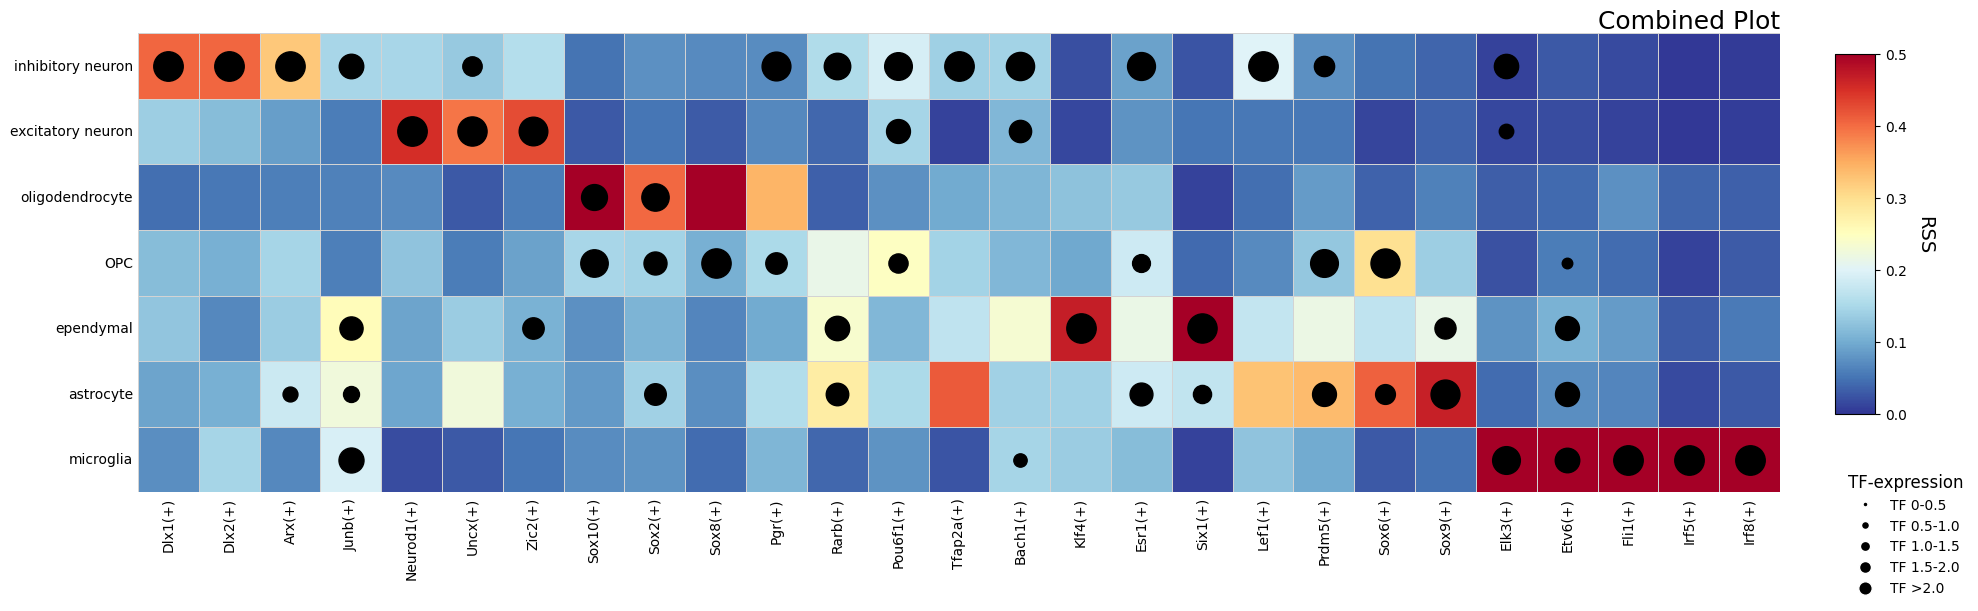

/tmp/ipykernel_1704469/2564497544.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以适应颜色条和图例


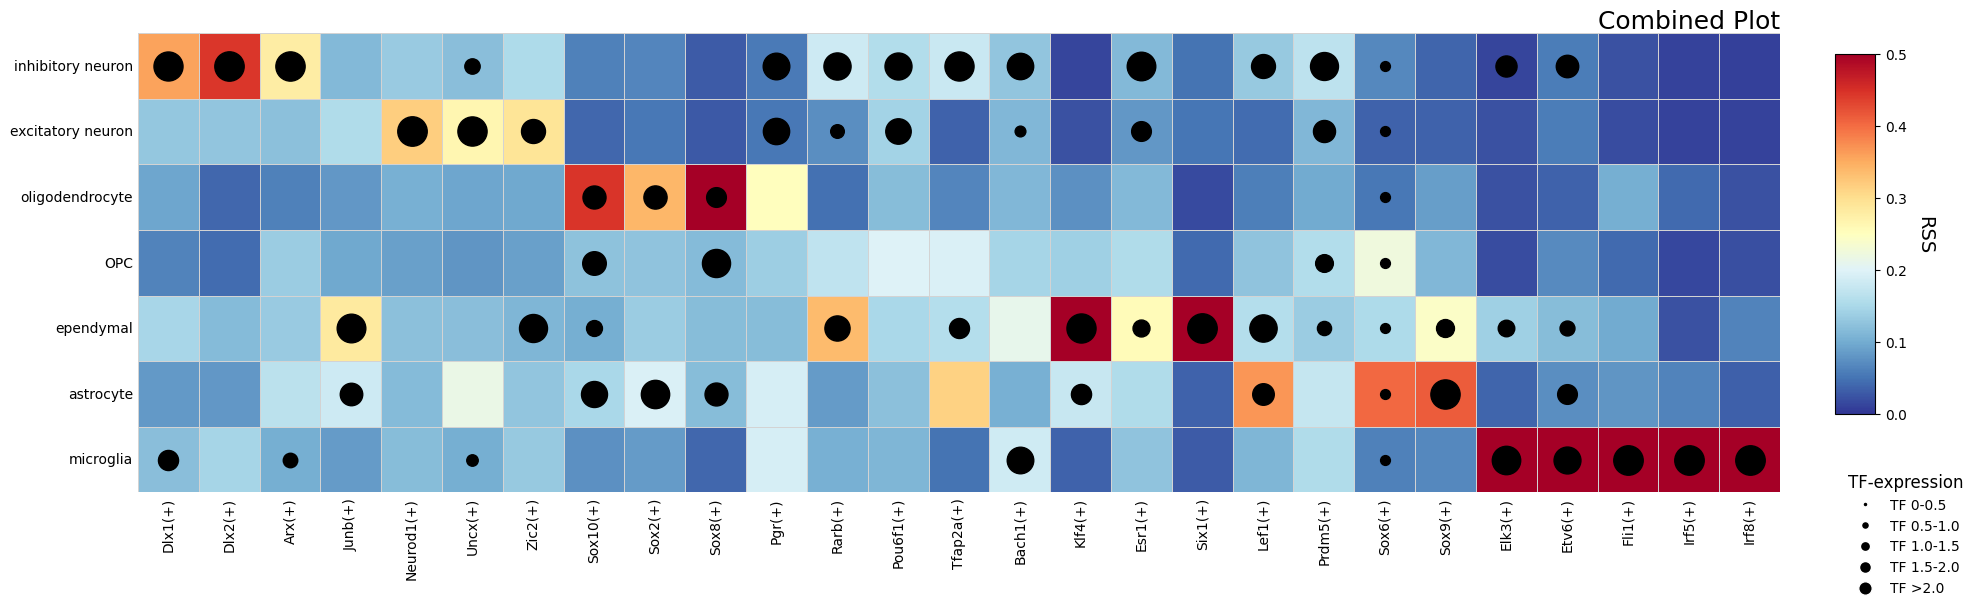

/tmp/ipykernel_1704469/2564497544.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以适应颜色条和图例


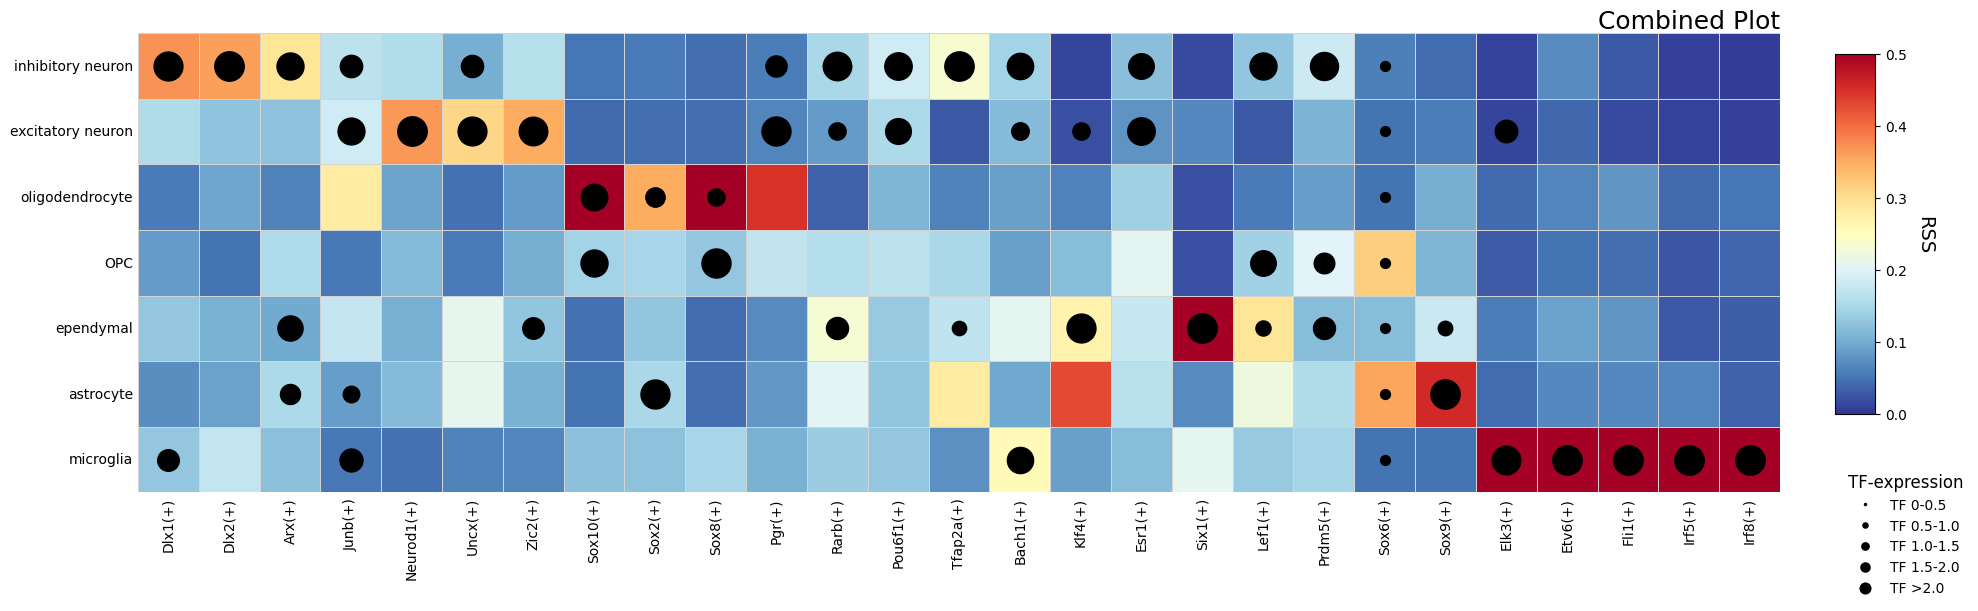

/tmp/ipykernel_1704469/2564497544.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以适应颜色条和图例


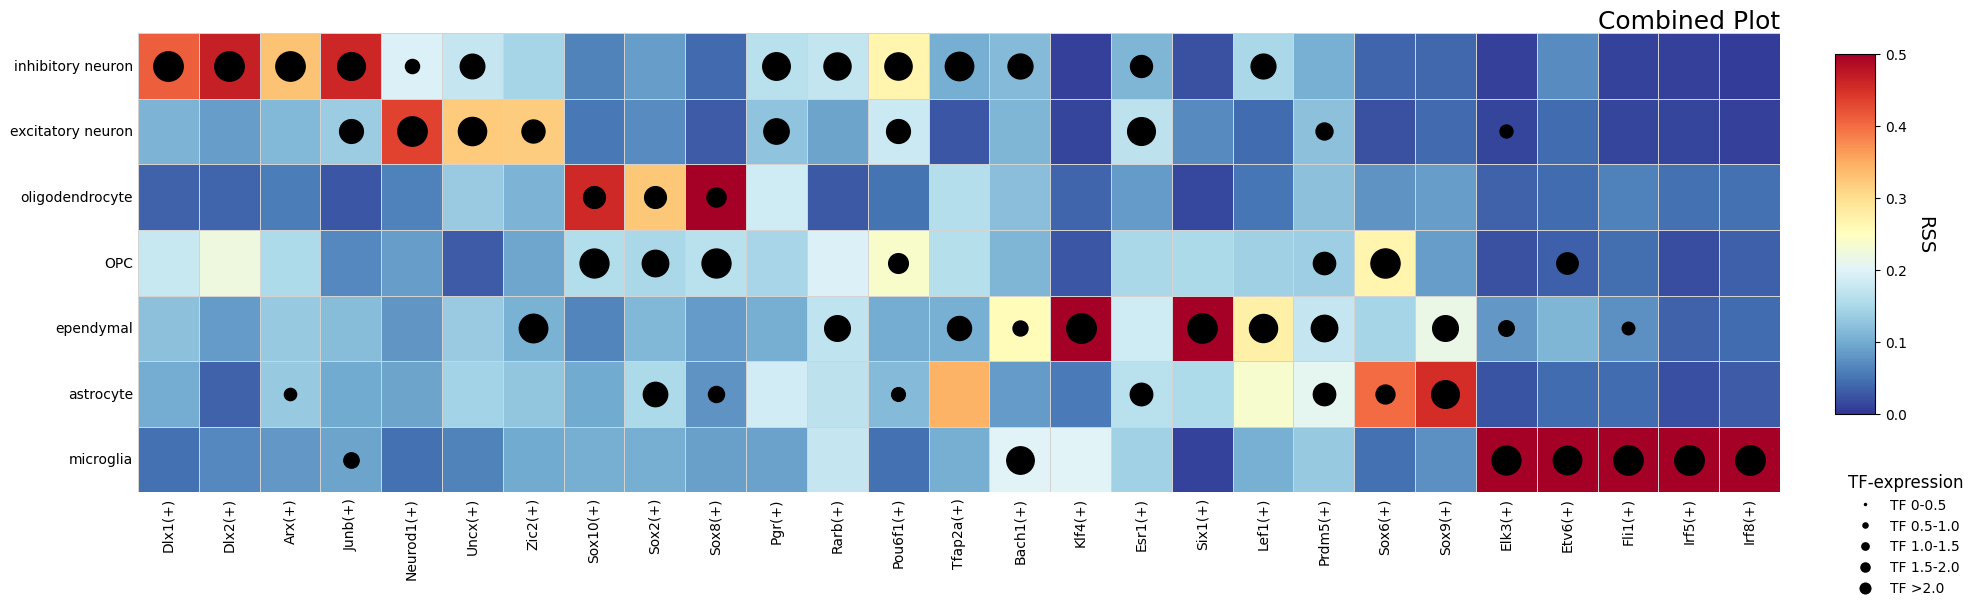

/tmp/ipykernel_1704469/2564497544.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以适应颜色条和图例


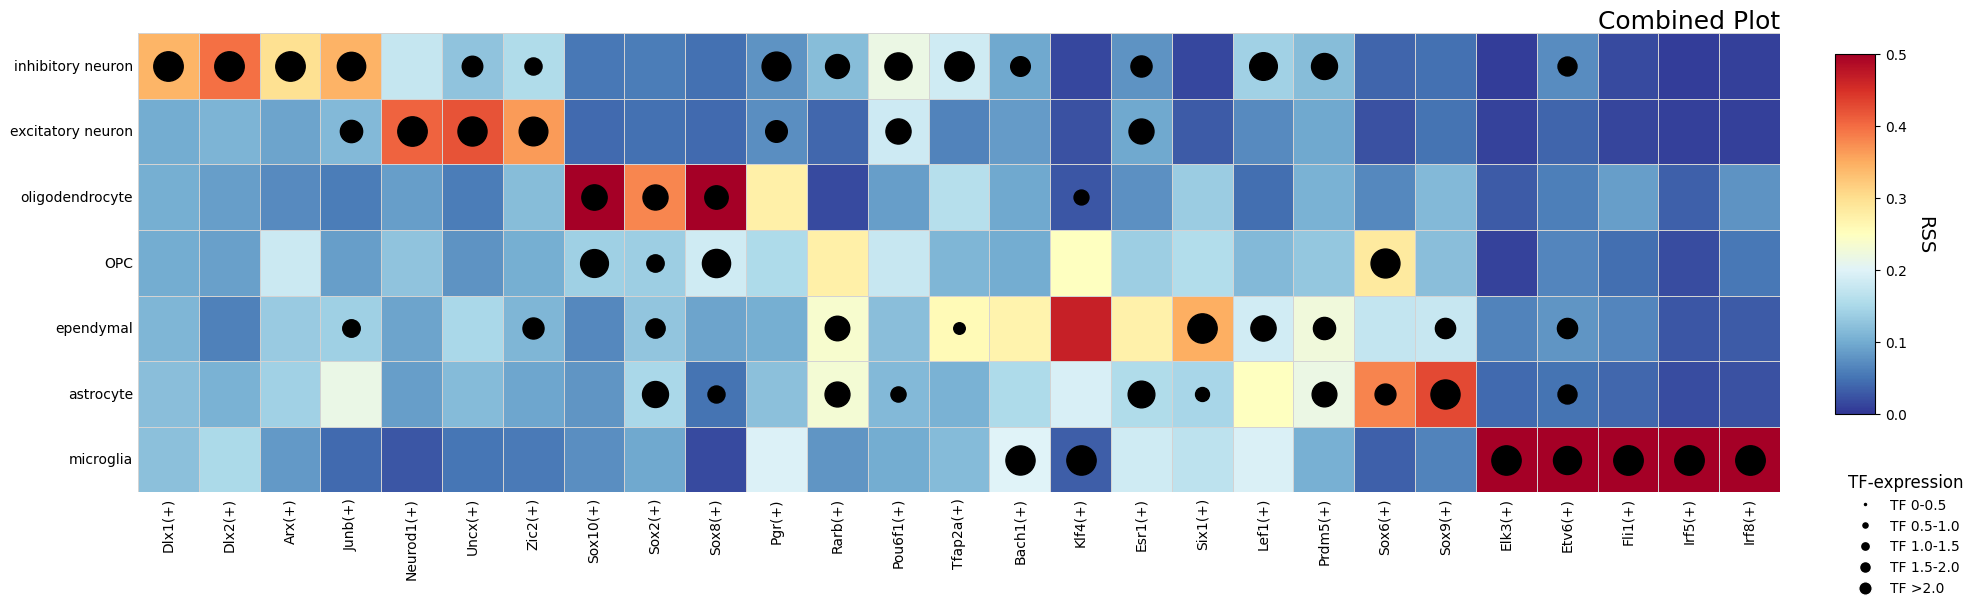

In [27]:
sel_tf = ['Dlx1(+)','Dlx2(+)','Arx(+)','Junb(+)','Neurod1(+)','Uncx(+)','Zic2(+)','Sox10(+)','Sox2(+)','Sox8(+)','Pgr(+)','Rarb(+)',
          'Pou6f1(+)','Tfap2a(+)','Bach1(+)','Klf4(+)','Esr1(+)','Six1(+)','Lef1(+)','Prdm5(+)','Sox6(+)','Sox9(+)','Elk3(+)',
          'Etv6(+)','Fli1(+)','Irf5(+)','Irf8(+)']


for key in scdata.obs.species.unique():
    species_reg = {}
    species_tf = {}

    idx = scdata.obs.species == key
    subdata = scdata[idx,:]
    sub_exp = exp_data[idx,:]
    
    for ele in subdata.obs.celltype.unique():
        idx2 = subdata.obs.celltype == ele
        tmp = subdata[idx2,:].X.mean(axis = 0)
        species_reg[ele] = tmp

        tmp = np.array(sub_exp[idx2,:].X.mean(axis = 0)).reshape(-1)
        species_tf[ele] = tmp

    reg_df = pd.DataFrame(species_reg)

    reg_df = reg_df.T
    reg_df.columns = scdata.var.index
    reg_df = reg_df.loc[:,sel_tf]
    reg_df= reg_df.loc[scdata.obs.celltype.unique(),:]
    reg_df = sum_scale(reg_df)
    reg_df.to_csv(os.path.join(save_dir, f'{key}_regulation.csv')) 

    tf_df = pd.DataFrame(species_tf)
    tf_df = tf_df.T 
    tf_df.columns = scdata.var.index 
    tf_df = tf_df.loc[:,sel_tf]
    tf_df = tf_df.loc[scdata.obs.celltype.unique(),:]
    tf_df = z_scale(tf_df) 
    tf_df.to_csv(os.path.join(save_dir, f'{key}_tf.csv'))


    #plt.figure(figsize = (30,4))
    #sns.heatmap(reg_df, cmap = 'RdYlBu_r', vmax = 0.5)
    #plt.title(f'{key} brain regulation among 7 celltype')
    #plt.savefig(os.path.join(save_dir,f'{key}_brain_regulation_filter.pdf'), bbox_inches = 'tight')
    #plt.show() 

    #reg_df.to_csv(os.path.join(save_dir, f'{key}_regulation.csv'))


    dot_legend_thresholds = {
        #'<-0.5': 0.5, # 用于在图例中表示
        '0-0.5': 0,
        '0.5-1.0': 0.5,
        '1.0-1.5': 1.0,
        '1.5-2.0': 1.5,
        '>2.0': 2.0
    }

    # --- 4. 绘制单张图 ---
    fig, ax = plt.subplots(1, 1, figsize=(20, 6)) # 只创建一个图和 Axes 对象，调整整体大小

    # 绘制数据
    plot_abstract_heatmap_dots(
        ax=ax,
        heatmap_df=reg_df,
        dotplot_df=tf_df,
        title='Combined Plot', # 单张图的标题
        heatmap_color_min=HEATMAP_COLOR_MIN,
        heatmap_color_max=HEATMAP_COLOR_MAX,
        heatmap_cmap=HEATMAP_CMAP,
        dot_min_value=DOT_MIN_VALUE,
        dot_size_base=DOT_SIZE_BASE,
        dot_size_scale_factor=DOT_SIZE_SCALE_FACTOR
    )

    # --- 5. 添加公共颜色条和图例 (位置需要调整以适应单张图) ---

    # Heatmap 颜色条
    # 调整颜色条的位置，使其在单张图旁边
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.6]) # [left, bottom, width, height]
    norm = plt.Normalize(vmin=HEATMAP_COLOR_MIN, vmax=HEATMAP_COLOR_MAX)
    sm = plt.cm.ScalarMappable(cmap=HEATMAP_CMAP, norm=norm)
    sm.set_array([]) # 必需设置一个空数组
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('RSS', rotation=270, labelpad=20, fontsize=14)
    cbar.ax.tick_params(labelsize=10)

    # Dot plot 大小图例
    # 调整图例的位置，使其在单张图旁边
    legend_elements = []
    max_dot_val_for_legend = tf_df.max().max() # 获取当前图的最大点值用于图例映射

    for label, threshold_val in dot_legend_thresholds.items():
        if threshold_val < DOT_MIN_VALUE:
            s_val = DOT_SIZE_BASE / 2
        else:
            normalized_threshold = (threshold_val - DOT_MIN_VALUE) / (max_dot_val_for_legend - DOT_MIN_VALUE)
            s_val = normalized_threshold * DOT_SIZE_SCALE_FACTOR + DOT_SIZE_BASE
            
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor='black',
                                        markersize=np.sqrt(s_val)/2, # markersize 是半径，s 是面积
                                        label=f'TF {label}'))

    legend_ax = fig.add_axes([0.92, 0.05, 0.05, 0.1]) # [left, bottom, width, height]
    legend_ax.set_axis_off()
    legend_ax.legend(handles=legend_elements, loc='center left', frameon=False, title="TF-expression", fontsize=10, title_fontsize=12)


    plt.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以适应颜色条和图例
    save_path  = os.path.join(save_dir, f'{key}_reg_tf.pdf')
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


## show the celltype correlation based on the regulation

In [28]:
sel_tf = ['Dlx1(+)','Dlx2(+)','Arx(+)','Junb(+)','Neurod1(+)','Uncx(+)','Zic2(+)','Sox10(+)','Sox2(+)','Sox8(+)','Pgr(+)','Rarb(+)',
          'Pou6f1(+)','Tfap2a(+)','Bach1(+)','Klf4(+)','Esr1(+)','Six1(+)','Lef1(+)','Prdm5(+)','Sox6(+)','Sox9(+)','Elk3(+)',
          'Etv6(+)','Fli1(+)','Irf5(+)','Irf8(+)']

reg_dic = {}
for key in scdata.obs.species.unique():
    species_res = {}
    idx = scdata.obs.species == key
    subdata = scdata[idx,:]
    
    for ele in subdata.obs.celltype.unique():
        idx2 = subdata.obs.celltype == ele
        tmp = subdata[idx2,:].X.mean(axis = 0)
        species_res[ele] = tmp
    reg_dic[key] = species_res


df_list = []
for species in reg_dic:
    df = pd.DataFrame(reg_dic[species])

    reg_df = df.T
    reg_df.columns = scdata.var.index
    reg_df = reg_df.loc[:,sel_tf]
    reg_df= reg_df.loc[scdata.obs.celltype.unique(),:]
    reg_df = sum_scale(reg_df)

    new_idx = [f'{species}_{x}' for x in reg_df.index]
    reg_df.index = new_idx
    df_list.append(reg_df)
df = pd.concat(df_list)
df[df >= 0.5] = 0.5
print(df.shape)

(35, 27)


In [30]:
save_dir = 'corr_regulation'
os.makedirs(save_dir, exist_ok=True)

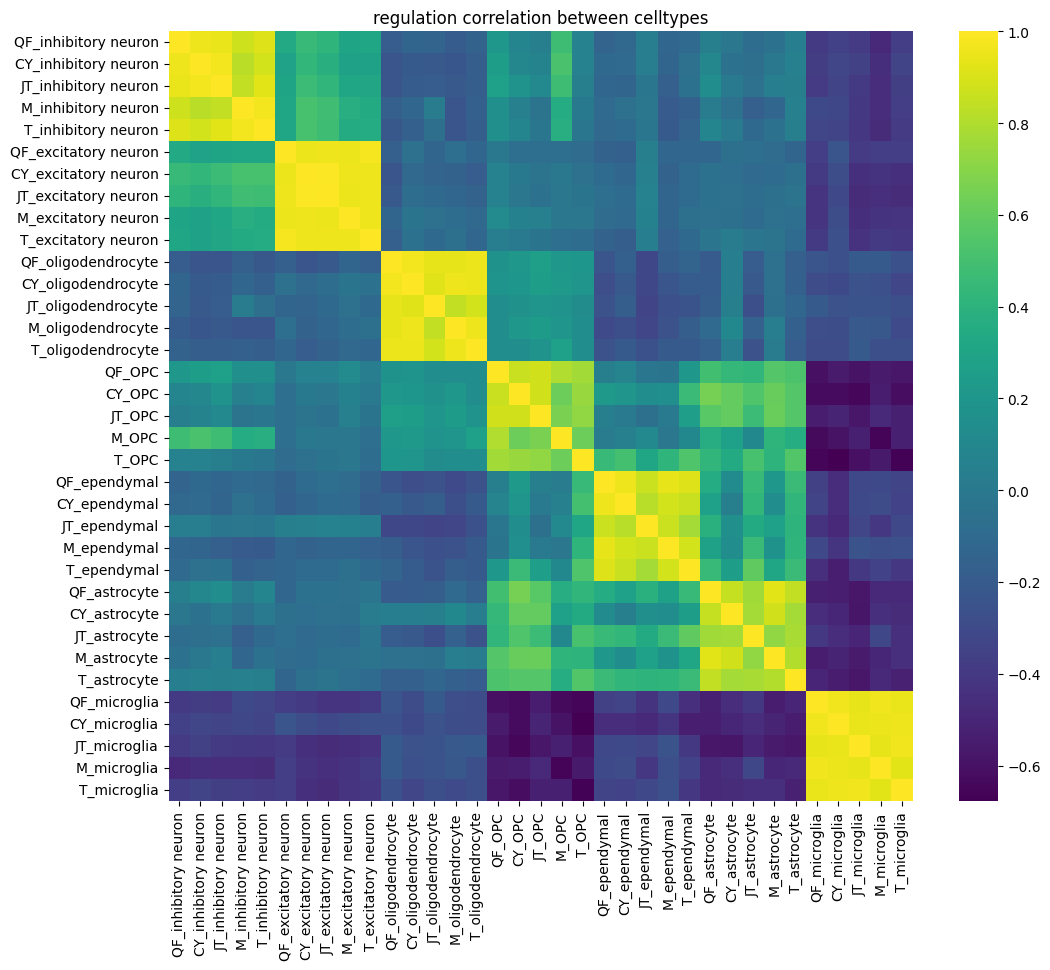

In [31]:
new_idx = []
for cell_type in scdata.obs.celltype.unique():
    for species in scdata.obs.species.unique():
        new_idx.append(species + '_' + cell_type)

df = df.loc[new_idx,:]

corr_df = df.T.corr('pearson')
corr_df.to_csv(os.path.join(save_dir,'regulation_corr.csv'))

plt.figure(figsize=(12,10))
sns.heatmap(df.T.corr('pearson'),cmap = 'viridis')
plt.title('regulation correlation between celltypes')
plt.savefig(os.path.join(save_dir,'regulation_corr.pdf'), bbox_inches = 'tight')
plt.show()

## For each species,  plot the regulation heatmap + dotplot combination. 


For each species, show the differences among differenct cell types from the regulation aspetc


In [ ]:
sel_tf = ['Dlx1(+)','Dlx2(+)','Arx(+)','Junb(+)','Neurod1(+)','Uncx(+)','Zic2(+)','Sox10(+)','Sox2(+)','Sox8(+)','Pgr(+)','Rarb(+)',
          'Pou6f1(+)','Tfap2a(+)','Bach1(+)','Klf4(+)','Esr1(+)','Six1(+)','Lef1(+)','Prdm5(+)','Sox6(+)','Sox9(+)','Elk3(+)',
          'Etv6(+)','Fli1(+)','Irf5(+)','Irf8(+)']

save_dir = 'species_tissues_regulation'
os.makedirs(save_dir, exist_ok=True)

for key in scdata.obs.species.unique():
    for tissue in scdata.obs.tissues.unique():
        species_reg = {}
        species_tf = {}

        idx = (scdata.obs.species == key).values & (scdata.obs.tissues == tissue).values
        subdata = scdata[idx,:]
        sub_exp = exp_data[idx,:]
        
        for ele in subdata.obs.celltype.unique():
            idx2 = subdata.obs.celltype == ele 
            if idx2.sum() >= 50:
                tmp = subdata[idx2,:].X.mean(axis = 0)
                species_reg[ele] = tmp

                tmp = np.array(sub_exp[idx2,:].X.mean(axis = 0)).reshape(-1)
                species_tf[ele] = tmp

        reg_df = pd.DataFrame(species_reg)

        new_index = []
        for ele in scdata.obs.celltype.unique():
            if ele in species_reg.keys():
                new_index.append(ele)
        
        reg_df = reg_df.T
        reg_df.columns = scdata.var.index
        reg_df = reg_df.loc[:,sel_tf]
        reg_df = reg_df.loc[new_index,:]
        reg_df = sum_scale(reg_df)
        reg_df.to_csv(os.path.join(save_dir, f'{key}_{tissue}_regulation.csv')) 

        tf_df = pd.DataFrame(species_tf)
        tf_df = tf_df.T 
        tf_df.columns = scdata.var.index 
        tf_df = tf_df.loc[:,sel_tf]
        tf_df = tf_df.loc[new_index,:]
        tf_df = z_scale(tf_df) 
        tf_df.to_csv(os.path.join(save_dir, f'{key}_{tissue}_tf.csv'))


        #plt.figure(figsize = (30,4))
        #sns.heatmap(reg_df, cmap = 'RdYlBu_r', vmax = 0.5)
        #plt.title(f'{key} brain regulation among 7 celltype')
        #plt.savefig(os.path.join(save_dir,f'{key}_brain_regulation_filter.pdf'), bbox_inches = 'tight')
        #plt.show() 

        #reg_df.to_csv(os.path.join(save_dir, f'{key}_regulation.csv'))


        dot_legend_thresholds = {
            #'<-0.5': 0.5, # 用于在图例中表示
            '0-0.5': 0,
            '0.5-1.0': 0.5,
            '1.0-1.5': 1.0,
            '1.5-2.0': 1.5,
            '>2.0': 2.0
        }

        # --- 4. 绘制单张图 ---
        fig, ax = plt.subplots(1, 1, figsize=(20, 6)) # 只创建一个图和 Axes 对象，调整整体大小

        # 绘制数据
        plot_abstract_heatmap_dots(
            ax=ax,
            heatmap_df=reg_df,
            dotplot_df=tf_df,
            title='Combined Plot', # 单张图的标题
            heatmap_color_min=HEATMAP_COLOR_MIN,
            heatmap_color_max=HEATMAP_COLOR_MAX,
            heatmap_cmap=HEATMAP_CMAP,
            dot_min_value=DOT_MIN_VALUE,
            dot_size_base=DOT_SIZE_BASE,
            dot_size_scale_factor=DOT_SIZE_SCALE_FACTOR
        )

        # --- 5. 添加公共颜色条和图例 (位置需要调整以适应单张图) ---

        # Heatmap 颜色条
        # 调整颜色条的位置，使其在单张图旁边
        cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.6]) # [left, bottom, width, height]
        norm = plt.Normalize(vmin=HEATMAP_COLOR_MIN, vmax=HEATMAP_COLOR_MAX)
        sm = plt.cm.ScalarMappable(cmap=HEATMAP_CMAP, norm=norm)
        sm.set_array([]) # 必需设置一个空数组
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_label('RSS', rotation=270, labelpad=20, fontsize=14)
        cbar.ax.tick_params(labelsize=10)

        # Dot plot 大小图例
        # 调整图例的位置，使其在单张图旁边
        legend_elements = []
        max_dot_val_for_legend = tf_df.max().max() # 获取当前图的最大点值用于图例映射

        for label, threshold_val in dot_legend_thresholds.items():
            if threshold_val < DOT_MIN_VALUE:
                s_val = DOT_SIZE_BASE / 2
            else:
                normalized_threshold = (threshold_val - DOT_MIN_VALUE) / (max_dot_val_for_legend - DOT_MIN_VALUE)
                s_val = normalized_threshold * DOT_SIZE_SCALE_FACTOR + DOT_SIZE_BASE
                
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                            markerfacecolor='black',
                                            markersize=np.sqrt(s_val)/2, # markersize 是半径，s 是面积
                                            label=f'TF {label}'))

        legend_ax = fig.add_axes([0.92, 0.05, 0.05, 0.1]) # [left, bottom, width, height]
        legend_ax.set_axis_off()
        legend_ax.legend(handles=legend_elements, loc='center left', frameon=False, title="TF-expression", fontsize=10, title_fontsize=12)


        plt.tight_layout(rect=[0, 0, 0.9, 1]) # 调整布局以适应颜色条和图例
        save_path  = os.path.join(save_dir, f'{key}_{tissue}_reg_tf.pdf')
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()


## quantify the relation between each tissue and echolocation traits based on regulation. 

The metrics is the same as the one in 10_grn_analysis.ipynb



In [54]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

def eval(df, n1=3):
    """
    将 df 分为前 n1 行和后 (len-n1) 行，计算三类距离
    """
    group1 = df.iloc[:n1]
    group2 = df.iloc[n1:]
    
    method = 'euclidean'
    d1 = cdist(group1, group1, method)[np.triu_indices(n1, k=1)]
    d2 = cdist(group2, group2, method)
    d2 = [d2[0,1]] if d2.shape[0] == 2 else []
    d3 = cdist(group1, group2, method).flatten()
    
    diff_score = 2*d3.mean() - (d2 + d1.mean())
    return diff_score



In [89]:
res_dic = {}


for tissue in scdata.obs.tissues.unique():
    tissue_res = {}
    for species in scdata.obs.species.unique():
        idx_1 = scdata.obs.tissues == tissue
        idx_2 = scdata.obs.species == species
        idx = idx_1 & idx_2
        tissue_res[species] = scdata[idx,:].X.mean(axis = 0)
    df = pd.DataFrame(tissue_res).T
    df.columns = scdata.var.index
    df = df.loc[['CY','JT','T','M','QF'],:]
    df = sum_scale(df)

    res_dic[tissue] = eval(df)[0]
for key in res_dic:
    print(key, res_dic[key])

QN 0.049264272433282574
PC 0.10961884106243369
CT 0.03222942231034143
HM 0.11671806803127494
NG 0.08997466503225748
BQ 0.08853011465380112
XQ 0.05212333412009462
YB 0.08677934040574087


In [87]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
diff = np.array(list(res_dic.values()))
scaler = StandardScaler() #MinMaxScaler()
new_diff = scaler.fit_transform(diff[:,np.newaxis])

new_res = {}
count = 0
for key in res_dic:
    new_res[key] = new_diff[count,0]
    count += 1 
for key in new_res:
    print(key, new_res[key])

QN -1.019817540151974
PC 1.1106641078260706
CT -1.6211379768198535
HM 1.361262747091994
NG 0.41723596356912684
BQ 0.3662441639293799
XQ -0.9188943028140106
YB 0.30444283736926686


## quantify the relation between each celltype and echolocation traits based on regulation. 

The metrics is the same as the one in 10_grn_analysis.ipynb

In [84]:
res_dic = {}

hmdata = scdata[scdata.obs.tissues == 'HM',:]

for celltype in hmdata.obs.celltype.unique():
    cell_res = {}
    for species in hmdata.obs.species.unique():
        idx_1 = hmdata.obs.celltype == celltype
        idx_2 = hmdata.obs.species == species
        idx = idx_1 & idx_2
        cell_res[species] = hmdata[idx,:].X.mean(axis = 0)

    df = pd.DataFrame(cell_res).T
    df.columns = hmdata.var.index
    df = df.loc[['CY','JT','T','M','QF'],:]
    #df = _scale(df)

    res_dic[celltype] = eval(df)[0]
for key in res_dic:
    print(key, res_dic[key])

excitatory neuron 0.2648063053199222
microglia 0.016235270284595038
inhibitory neuron 0.18466040171785225
oligodendrocyte 0.0427749799434719
OPC 0.1978226786961781
astrocyte 0.1432547688101513
ependymal 0.02548339932103616


In [85]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
diff = np.array(list(res_dic.values()))
scaler = StandardScaler() #MinMaxScaler()
new_diff = scaler.fit_transform(diff[:,np.newaxis])

new_res = {}
count = 0
for key in res_dic:
    new_res[key] = new_diff[count,0]
    count += 1 
for key in new_res:
    print(key, new_res[key])

excitatory neuron 1.5460553888417534
microglia -1.20288667955415
inhibitory neuron 0.6597234556379459
oligodendrocyte -0.9093845651427461
OPC 0.8052848115556076
astrocyte 0.2018193955274811
ependymal -1.1006118068658919
